# Import libraries

In [1]:
import jalali_pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pytse_client as tse
from pytse_client.download import download_financial_indexes

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import ta

from zigzag import peak_valley_pivots


# Import data

In [2]:
marketIndex = download_financial_indexes(symbols = 'شاخص كل', write_to_csv = True, include_jdate = True)
marketIndex = marketIndex['شاخص كل']
marketIndex.rename(columns = {'value': 'TEDPIX'}, inplace = True)
print(f'Shape of TEDPIX: {marketIndex.shape}')
marketIndex.head()

Shape of TEDPIX: (3318, 3)


,jdate,TEDPIX,date
0,1387-09-14,9248.9,2008-12-04
1,1387-09-15,9248.9,2008-12-05
2,1387-09-16,9178.3,2008-12-06
3,1387-09-17,9130.5,2008-12-07
4,1387-09-18,9089.2,2008-12-08


In [62]:
#sipa = tse.download(symbols = ["خساپا"], write_to_csv = False, include_jdate = True)

tse.download(symbols = ['فولاد'], write_to_csv = True, include_jdate = True)
folad = tse.Ticker(symbol = 'فولاد',  adjust = True)
foladHist = folad.history
print(f'Shape of Folad price history: {foladHist.shape}')
foladHist.head()

Shape of Folad price history: (3412, 10)


,date,open,high,low,adjClose,value,volume,count,yesterday,close
0,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0
1,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0
2,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0
3,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0
4,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0


In [63]:
foladHist_new = pd.concat(
    [
        foladHist, 
        foladHist.shift(1).drop(columns = 'date').add_prefix('last_')
    ], 
    axis = 1
)
foladHist_new

,date,open,high,low,adjClose,value,volume,count,yesterday,close,last_open,last_high,last_low,last_adjClose,last_value,last_volume,last_count,last_yesterday,last_close
0,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,16.0,16.0,16.0,16.0,8.894372e+11,468077431.0,7736.0,16.0,16.0
2,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,16.0,16.0,16.0,16.0,1.938795e+11,100041000.0,9214.0,16.0,16.0
3,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,16.0,16.0,16.0,16.0,2.492415e+11,126270939.0,5862.0,16.0,16.0
4,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0,16.0,16.0,16.0,16.0,5.166638e+10,26705128.0,1901.0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,2022-09-03,5120.0,5170.0,5020.0,5090.0,331643846300,65174611,5148,5140.0,5080.0,5160.0,5190.0,5120.0,5140.0,1.854448e+11,36092715.0,3911.0,5170.0,5120.0
3408,2022-09-04,5100.0,5180.0,5070.0,5090.0,215396544090,42292675,3891,5090.0,5090.0,5120.0,5170.0,5020.0,5090.0,3.316438e+11,65174611.0,5148.0,5140.0,5080.0
3409,2022-09-05,5150.0,5150.0,5050.0,5080.0,247383720220,48675596,4011,5090.0,5060.0,5100.0,5180.0,5070.0,5090.0,2.153965e+11,42292675.0,3891.0,5090.0,5090.0
3410,2022-09-06,5080.0,5100.0,5020.0,5060.0,175608551800,34701518,3234,5080.0,5070.0,5150.0,5150.0,5050.0,5080.0,2.473837e+11,48675596.0,4011.0,5090.0,5060.0


In [9]:
foladClient = folad.client_types
print(f"Shape of Folad's client history: {foladClient.shape}")
foladClient.to_csv('foladClient.csv')
foladClient.head()

Shape of Folad's client history: (3022, 18)


,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,20220831,1930,11,916,6,27457268,8635447,27308224,8784491,141040095110,44404707500,140295325160,45149477450,5136.712622,5137.475259,5142.143481,5139.680540,149044.0
1,20220830,2444,7,924,13,38097398,7229124,29888948,15437574,196977256850,37477816580,154686787880,79768285550,5170.359846,5175.384155,5184.281883,5167.151623,8208450.0
2,20220829,2451,11,1073,14,43176349,6834953,33561119,16450183,225913038510,35737131390,175617143380,86033026520,5232.333065,5232.755898,5228.584804,5229.913036,9615230.0
3,20220828,2007,12,893,9,40137018,9261832,46815945,2582905,211585643300,48823303450,246765627630,13643319120,5271.583537,5270.973973,5271.452068,5282.160637,-6678927.0
4,20220827,2320,8,1149,12,44676661,6970789,40468322,11179128,238012916220,37188912190,215610937660,59590890750,5327.455340,5327.894190,5334.964548,5330.549105,4208339.0


# Indicators

In [64]:
from indicator_features import EMA
emaCols = EMA(foladHist)
emaCols

,EMA_5d,last_EMA_5d,EMA_40d,last_EMA_40d,EMA_buy,EMA_position
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,16.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3407,5174.100117,5216.150176,5323.803347,5335.793262,NaN,0.0
3408,5146.066745,5174.100117,5312.398306,5323.803347,NaN,0.0
3409,5124.044497,5146.066745,5301.061803,5312.398306,NaN,0.0
3410,5102.696331,5124.044497,5289.302691,5301.061803,NaN,0.0


In [65]:
from indicator_features import MACD
macdCols = MACD(foladHist)
macdCols

,adjClose,MACD,MACD_diff,MACD_signal,MACD_buy,MACD_position
0,16.0,NaN,NaN,NaN,NaN,NaN
1,16.0,NaN,NaN,NaN,NaN,NaN
2,16.0,NaN,NaN,NaN,NaN,NaN
3,16.0,NaN,NaN,NaN,NaN,NaN
4,16.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3407,5090.0,-42.739122,-42.105760,-0.633362,NaN,0.0
3408,5090.0,-53.494956,-42.289275,-11.205681,NaN,0.0
3409,5080.0,-62.109982,-40.723441,-21.386541,NaN,0.0
3410,5060.0,-69.747283,-38.688593,-31.058689,NaN,0.0


In [66]:
from indicator_features import STOCHASTIC
stochasticCols = STOCHASTIC(foladHist)
stochasticCols

,STOCH_osci,STOCH_signal,last_STOCH_osci,last_STOCH_signal,STOCH_buy,STOCH_position
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3407,7.228916,11.984705,0.000000,17.919875,NaN,0.0
3408,8.433735,7.803189,7.228916,11.984705,NaN,0.0
3409,5.479452,4.228421,8.433735,7.803189,NaN,0.0
3410,7.042254,5.636871,5.479452,4.228421,NaN,0.0


In [72]:
from indicator_features import BB
bbCols = BB(foladHist_new)
bbCols

,BB_bbh,BB_bbl,last_BB_bbh,last_BB_bbl,BB_buy,BB_position
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
3407,5783.422448,4960.177552,5791.081665,4945.018335,NaN,0.0
3408,5786.262611,4953.637389,5783.422448,4960.177552,NaN,0.0
3409,5792.480994,4937.519006,5786.262611,4953.637389,NaN,0.0
3410,5800.855033,4911.144967,5792.480994,4937.519006,NaN,0.0


In [71]:
from indicator_features import SMA
smaCols = SMA(foladHist)
smaCols

,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_buy,SMA_position
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3407,5256.0,5371.80,5368.05,5310.700000,5301.44,5305.48,5431.8875,NaN,1.0
3408,5223.0,5369.95,5371.80,5307.733333,5297.32,5301.44,5425.2000,NaN,1.0
3409,5200.0,5365.00,5369.95,5303.500000,5293.00,5297.32,5417.8625,NaN,1.0
3410,5179.0,5356.00,5365.00,5293.900000,5286.68,5293.00,5411.2750,NaN,1.0


In [70]:
from indicator_features import RSI
rsiCols = RSI(foladHist)
rsiCols

,RSI,RSI_buy,RSI_position
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
3407,37.638238,NaN,0.0
3408,37.638238,NaN,0.0
3409,37.193125,NaN,0.0
3410,36.273885,NaN,0.0


# Concat

In [73]:
foladDf = pd.concat(
    [
        foladHist,
        emaCols,
        macdCols,
        bbCols,
        smaCols,
        rsiCols        
    ],
    axis = 1
) # 3412 rows × 53 columns

foladDf.dropna(
    axis = 'columns', 
    thresh = len(foladDf) - 81,
    inplace = True
) # 3412 rows × 43 columns

foladDf.dropna(
    axis = 'index', 
    how = 'any',
    inplace = True
) # 3333 rows × 40 columns

foladDf


,date,open,high,low,adjClose,value,volume,count,yesterday,close,...,last_BB_bbl,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,RSI,RSI_position
79,2007-07-11,20.0,20.0,20.0,20.0,32801833890,13701685,701,19.0,20.0,...,15.070551,18.4,17.50,17.25,16.666667,16.04,15.94,15.9000,88.416757,0.0
80,2007-07-14,20.0,20.0,20.0,20.0,101037157516,41484855,2611,20.0,20.0,...,15.263932,18.7,17.70,17.50,16.833333,16.12,16.04,15.9500,88.416757,0.0
81,2007-07-15,20.0,20.0,20.0,20.0,2249683461,942473,121,20.0,20.0,...,15.325132,18.9,17.90,17.70,17.000000,16.20,16.12,16.0000,88.416757,0.0
82,2007-07-16,20.0,20.0,20.0,20.0,55551799076,23338850,1586,20.0,20.0,...,15.458689,19.1,18.10,17.90,17.166667,16.30,16.20,16.0500,88.416757,0.0
83,2007-07-17,20.0,20.0,19.0,20.0,41409372184,17354847,1497,20.0,20.0,...,15.658689,19.3,18.25,18.10,17.333333,16.40,16.30,16.1000,88.416757,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,2022-09-03,5120.0,5170.0,5020.0,5090.0,331643846300,65174611,5148,5140.0,5080.0,...,4945.018335,5256.0,5371.80,5368.05,5310.700000,5301.44,5305.48,5431.8875,37.638238,0.0
3408,2022-09-04,5100.0,5180.0,5070.0,5090.0,215396544090,42292675,3891,5090.0,5090.0,...,4960.177552,5223.0,5369.95,5371.80,5307.733333,5297.32,5301.44,5425.2000,37.638238,0.0
3409,2022-09-05,5150.0,5150.0,5050.0,5080.0,247383720220,48675596,4011,5090.0,5060.0,...,4953.637389,5200.0,5365.00,5369.95,5303.500000,5293.00,5297.32,5417.8625,37.193125,0.0
3410,2022-09-06,5080.0,5100.0,5020.0,5060.0,175608551800,34701518,3234,5080.0,5070.0,...,4937.519006,5179.0,5356.00,5365.00,5293.900000,5286.68,5293.00,5411.2750,36.273885,0.0


# model

In [75]:
pivots = peak_valley_pivots(
    foladHist['adjClose'], 
    0.05, 
    -0.05
)
y = pivots[-len(foladDf.index):]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    foladDf.drop(columns = ['date']).values, 
    y, 
    shuffle = False, 
    random_state = 0)

In [106]:
from model import RFClf
trainPred, testPred, trainProb, testProb, featureImport, trainClassReport, testClassReport = RFClf(X_train, y_train, X_test, y_test)

c:\Users\hanif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\hanif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\hanif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [105]:
print(trainClassReport)

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        78
           0       1.00      1.00      1.00      2343
           1       1.00      0.99      0.99        78

    accuracy                           1.00      2499
   macro avg       1.00      1.00      1.00      2499
weighted avg       1.00      1.00      1.00      2499



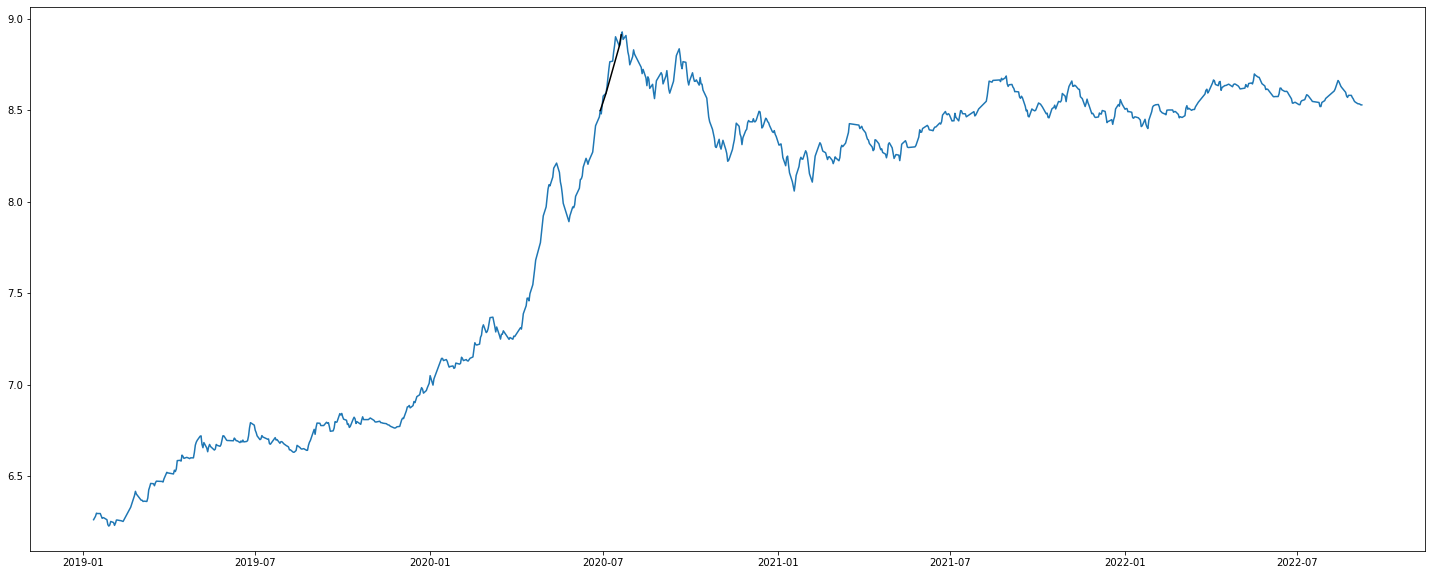

In [104]:
plt.figure(figsize = (25, 10))
plt.plot(foladHist['date'][-len(X_test):], np.log(foladHist['adjClose'])[-len(X_test):])

plt.plot(foladHist['date'][-len(X_test):][testPred != 0], np.log(foladHist['adjClose'][-len(X_test):][testPred != 0]), 'k-')
#plt.scatter(foladHist['date'][pivots == 1], np.log(foladHist['adjClose'][pivots == 1]), color='r')
#plt.scatter(foladHist['date'][pivots == -1], np.log(foladHist['adjClose'][pivots == -1]), color='g')

# Data pre-processing

In [5]:
foladHist.insert(1,'step', np.arange(1, len(foladHist) + 1))
foladHist = pd.merge(foladHist, marketIndex, how = 'left', on = 'date')

cols = ['date', 'jdate', 'step', 'TEDPIX',
        'open', 'close', 'high', 'low', 'adjClose', 
        'value', 'volume', 'count', 'yesterday']
foladHist = foladHist[cols]

foladHist.head()

,date,jdate,step,TEDPIX,open,close,high,low,adjClose,value,volume,count,yesterday
0,2007-03-11,NaN,1,NaN,16.0,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0
1,2007-03-12,NaN,2,NaN,16.0,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0
2,2007-03-13,NaN,3,NaN,16.0,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0
3,2007-03-14,NaN,4,NaN,16.0,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0
4,2007-03-17,NaN,5,NaN,16.0,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0


In [6]:
foladClient['date'] = pd.to_datetime(foladClient['date'])
foladClient.iloc[:, 1: 13] = foladClient.iloc[:, 1: 13].astype('float')

foladClient['Enter_individual_money'] = foladClient['individual_buy_value'] - foladClient['individual_sell_value']
foladClient['Individual_buy_per_capita'] = foladClient['individual_buy_value'] / foladClient['individual_buy_count']
foladClient['Individual_sell_per_capita'] = foladClient['individual_sell_value'] / foladClient['individual_sell_count']
foladClient['Individual_buy_power_to_Individual_sell'] = foladClient['Individual_buy_per_capita'] / foladClient['Individual_sell_per_capita']

foladClient.head()

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,...,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,Enter_individual_money,Individual_buy_per_capita,Individual_sell_per_capita,Individual_buy_power_to_Individual_sell
0,2022-08-31,1930.0,11.0,916.0,6.0,27457268.0,8635447.0,27308224.0,8784491.0,1.410401e+11,...,4.514948e+10,5136.712622,5137.475259,5142.143481,5139.680540,149044.0,7.447700e+08,7.307777e+07,1.531608e+08,0.477131
1,2022-08-30,2444.0,7.0,924.0,13.0,38097398.0,7229124.0,29888948.0,15437574.0,1.969773e+11,...,7.976829e+10,5170.359846,5175.384155,5184.281883,5167.151623,8208450.0,4.229047e+10,8.059626e+07,1.674099e+08,0.481431
2,2022-08-29,2451.0,11.0,1073.0,14.0,43176349.0,6834953.0,33561119.0,16450183.0,2.259130e+11,...,8.603303e+10,5232.333065,5232.755898,5228.584804,5229.913036,9615230.0,5.029590e+10,9.217178e+07,1.636693e+08,0.563159
3,2022-08-28,2007.0,12.0,893.0,9.0,40137018.0,9261832.0,46815945.0,2582905.0,2.115856e+11,...,1.364332e+10,5271.583537,5270.973973,5271.452068,5282.160637,-6678927.0,-3.517998e+10,1.054238e+08,2.763333e+08,0.381510
4,2022-08-27,2320.0,8.0,1149.0,12.0,44676661.0,6970789.0,40468322.0,11179128.0,2.380129e+11,...,5.959089e+10,5327.455340,5327.894190,5334.964548,5330.549105,4208339.0,2.240198e+10,1.025918e+08,1.876509e+08,0.546716


In [7]:
foladHist = pd.merge(foladHist, foladClient.iloc[:, [0, -4, -3, -2, -1]], how = 'left', on = 'date')
foladHist.head()

,date,jdate,step,TEDPIX,open,close,high,low,adjClose,value,volume,count,yesterday,Enter_individual_money,Individual_buy_per_capita,Individual_sell_per_capita,Individual_buy_power_to_Individual_sell
0,2007-03-11,NaN,1,NaN,16.0,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,NaN,NaN,NaN,NaN
1,2007-03-12,NaN,2,NaN,16.0,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,NaN,NaN,NaN,NaN
2,2007-03-13,NaN,3,NaN,16.0,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,NaN,NaN,NaN,NaN
3,2007-03-14,NaN,4,NaN,16.0,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,NaN,NaN,NaN,NaN
4,2007-03-17,NaN,5,NaN,16.0,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,NaN,NaN,NaN,NaN


In [22]:
foladHist['jdate'] = foladHist['date'].jalali.to_jalali()

foladHist['year'] = foladHist['jdate'].jalali.year
foladHist['month'] = foladHist['jdate'].jalali.month
foladHist['quarter'] = foladHist['jdate'].jalali.quarter
foladHist['day'] = foladHist['jdate'].jalali.day
foladHist['weekday'] = foladHist['jdate'].jalali.weekday

foladHist

,date,jdate,step,TEDPIX,open,close,high,low,adjClose,value,...,yesterday,Enter_individual_money,Individual_buy_per_capita,Individual_sell_per_capita,Individual_buy_power_to_Individual_sell,year,month,quarter,day,weekday
0,2007-03-11,1385-12-20 00:00:00,1,NaN,16.0,16.0,16.0,16.0,16.0,889437216900,...,16.0,NaN,NaN,NaN,NaN,1385,12,4,20,1
1,2007-03-12,1385-12-21 00:00:00,2,NaN,16.0,16.0,16.0,16.0,16.0,193879458000,...,16.0,NaN,NaN,NaN,NaN,1385,12,4,21,2
2,2007-03-13,1385-12-22 00:00:00,3,NaN,16.0,16.0,16.0,16.0,16.0,249241504527,...,16.0,NaN,NaN,NaN,NaN,1385,12,4,22,3
3,2007-03-14,1385-12-23 00:00:00,4,NaN,16.0,16.0,16.0,16.0,16.0,51666379451,...,16.0,NaN,NaN,NaN,NaN,1385,12,4,23,4
4,2007-03-17,1385-12-26 00:00:00,5,NaN,16.0,16.0,16.0,16.0,16.0,28239006789,...,16.0,NaN,NaN,NaN,NaN,1385,12,4,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,2022-08-27,1401-06-05 00:00:00,3403,1450045.2,5380.0,5320.0,5380.0,5300.0,5330.0,275201828410,...,5330.0,2.240198e+10,1.025918e+08,1.876509e+08,0.546716,1401,6,2,5,0
3403,2022-08-28,1401-06-06 00:00:00,3404,1444086.8,5350.0,5260.0,5350.0,5240.0,5270.0,260408946750,...,5330.0,-3.517998e+10,1.054238e+08,2.763333e+08,0.381510,1401,6,2,6,1
3404,2022-08-29,1401-06-07 00:00:00,3405,1445139.0,5270.0,5210.0,5280.0,5200.0,5230.0,261650169900,...,5270.0,5.029590e+10,9.217178e+07,1.636693e+08,0.563159,1401,6,2,7,2
3405,2022-08-30,1401-06-08 00:00:00,3406,1441217.1,5200.0,5130.0,5280.0,5130.0,5170.0,234455073430,...,5230.0,4.229047e+10,8.059626e+07,1.674099e+08,0.481431,1401,6,2,8,3


# ZigZag

In [49]:
pivots = peak_valley_pivots(foladHist['adjClose'], 0.05, -0.05)
foladHist['label'] = pivots
foladHist.head()

,date,open,high,low,adjClose,value,volume,count,yesterday,close,...,SMA50d,last_SMA50d,SMA80d,RSI_buy,SMA_buy,SMA_position,RSI,last_RSI,RSI_position,label
0,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


([<matplotlib.patches.Wedge at 0x18c2aec3100>,
 [Text(-1.0741322602275074, 0.23714950461374817, '0'),
  Text(1.04240740195817, -0.351264584526847, '1'),
  Text(1.0936233210297985, -0.11827100954906225, '-1')])

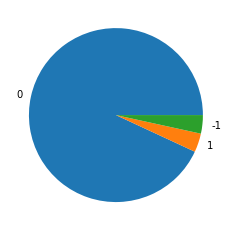

In [50]:
plt.pie(
    foladHist['label'].value_counts(),
    labels = foladHist['label'].value_counts().index
)

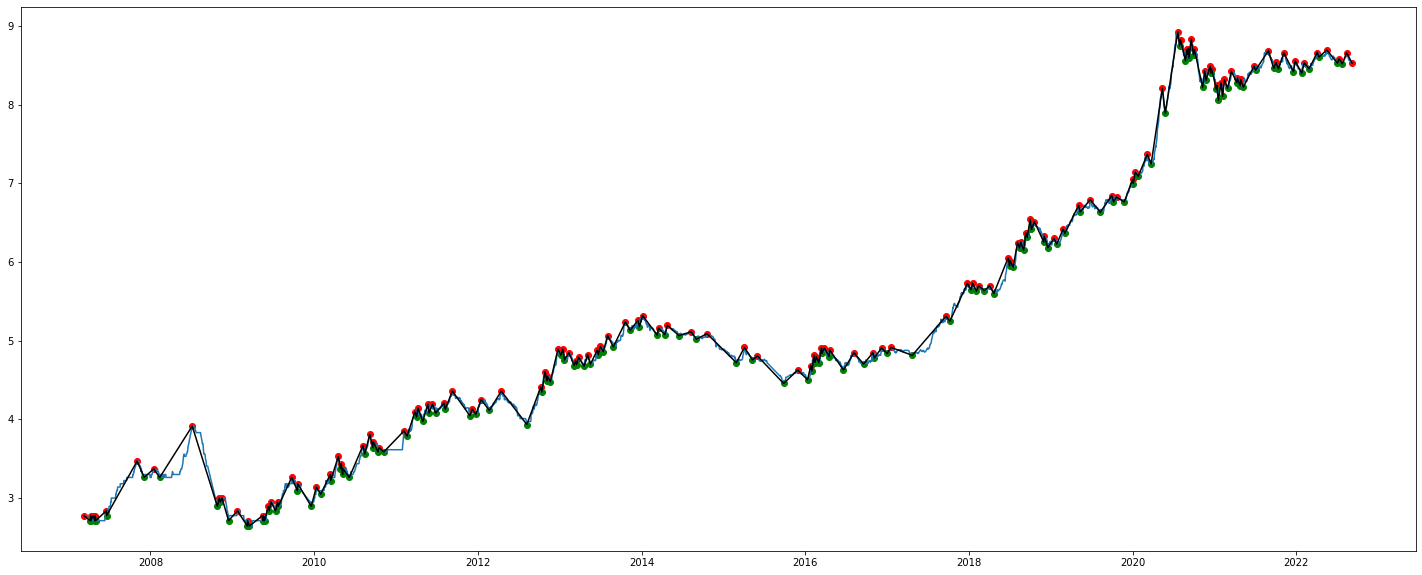

In [51]:
plt.figure(figsize = (25, 10))
plt.plot(foladHist['date'], np.log(foladHist['adjClose']))

plt.plot(foladHist['date'][pivots != 0], np.log(foladHist['adjClose'][pivots != 0]), 'k-')
plt.scatter(foladHist['date'][pivots == 1], np.log(foladHist['adjClose'][pivots == 1]), color='r')
plt.scatter(foladHist['date'][pivots == -1], np.log(foladHist['adjClose'][pivots == -1]), color='g')

In [34]:
foladHist.to_csv('dataset.csv')

# Rolling

In [11]:
'''
window = 100
foladHist['rolling lable'] = 0

foladMax = foladHist['adjClose'].rolling(window = window, min_periods = 5).max()
foladHist.loc[foladMax == foladHist['adjClose'], 'rolling lable'] = -1

foladMin = foladHist['adjClose'].rolling(window = window, min_periods = 5).min()
foladHist.loc[foladMin == foladHist['adjClose'], 'rolling lable'] = 1

plt.figure(figsize = (25, 10))
plt.plot(foladHist['date'], np.log(foladHist['adjClose']))

plt.plot(foladHist['date'][foladHist['rolling lable'] != 0], np.log(foladHist['adjClose'][foladHist['rolling lable'] != 0]), 'k-')
plt.scatter(foladHist['date'][foladHist['rolling lable'] == 1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == 1]), color='r')
plt.scatter(foladHist['date'][foladHist['rolling lable'] == -1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == -1]), color='g')
'''

"\nwindow = 100\nfoladHist['rolling lable'] = 0\n\nfoladMax = foladHist['adjClose'].rolling(window = window, min_periods = 5).max()\nfoladHist.loc[foladMax == foladHist['adjClose'], 'rolling lable'] = -1\n\nfoladMin = foladHist['adjClose'].rolling(window = window, min_periods = 5).min()\nfoladHist.loc[foladMin == foladHist['adjClose'], 'rolling lable'] = 1\n\nplt.figure(figsize = (25, 10))\nplt.plot(foladHist['date'], np.log(foladHist['adjClose']))\n\nplt.plot(foladHist['date'][foladHist['rolling lable'] != 0], np.log(foladHist['adjClose'][foladHist['rolling lable'] != 0]), 'k-')\nplt.scatter(foladHist['date'][foladHist['rolling lable'] == 1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == 1]), color='r')\nplt.scatter(foladHist['date'][foladHist['rolling lable'] == -1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == -1]), color='g')\n"

# Candel Plot

In [8]:
fig = make_subplots(
    rows = 2, 
    cols = 1, 
    shared_xaxes = True, 
    vertical_spacing = 0.03, 
    subplot_titles = ('OHLC', 'Volume'), 
    row_width = [0.2, 0.7]
)

fig.add_trace(
    go.Candlestick(
        x = foladHist['date'],
        open = foladHist['open'],
        high = foladHist['high'],
        low = foladHist['low'],
        close = foladHist['adjClose']
    ),
    row = 1, col = 1
)

fig.add_trace(
    go.Bar(
        x = foladHist['date'],
        y = foladHist['volume'], 
        showlegend = False
        ),
        row = 2, col = 1
)
fig.update(layout_xaxis_rangeslider_visible = False)
fig.show()